In [1]:
import collections
from matplotlib import pyplot as plt

In [ ]:
WORKSPACE = "/data/gordanlab/samkim/dna-repair-tf"

In [2]:
# Run on cluster instead.
# import subprocess
# subprocess.call(["{}/mut-profile.cl.sh".format(WORKSPACE)])

In [13]:
def get_dists(mut_dataset_name):
    mut_list = []
    with open("{}/data/ssm.open.{}_centered.bed".format(WORKSPACE, mut_dataset_name)) as f:
        for line in f:
            _, dist, _, mut, tf = line.strip().split()
            mut_list.append((int(dist), mut, tf))

    counts = collections.defaultdict(int)
    for dist, _, _ in mut_list:
        counts[dist] += 1

    counts_by_tf = {}
    for dist, mut, tf in mut_list:
        if tf not in counts_by_tf:
            counts_by_tf[tf] = collections.defaultdict(int) # initialize
        counts_by_tf[tf][dist] += 1
    
    return counts, counts_by_tf

In [75]:
def plot_dists(counts, mut_dataset_name=None):
    X = sorted([int(dist) for dist in counts.keys()])
    y = [counts[dist] for dist in X]
    
    if len(X) == 0:
        print("List is empty")
        return
    
    plt.plot(X, y)
    plt.xlim(-1000, 1000)
    plt.ylim(0, None)
    plt.xlabel("Distance from TFBS center (bp)")
    plt.ylabel("Number of mutations")
    if mut_dataset_name is None:
        plt.title("Mutation profile for all TFs")
    else:
        plt.title("{} mutation profile for all TFs".format(mut_dataset_name))
    plt.show()

In [99]:
def plot_dists_by_tf(counts_by_tf, mut_dataset_name=None, num_rows=5, num_cols=6):
    ordered_counts = sorted(counts_by_tf.items(), key=lambda t: sum(t[1].values()), reverse=True)
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*1.5, num_rows*1.5), sharex='col', sharey='row')
    row, col = 0, 0
    for tf, counts in ordered_counts:
        X = sorted([int(dist) for dist in counts.keys()])
        y = [counts[dist] for dist in X]
        
        axs[row, col].plot(X, y)
        axs[row, col].set_xlim(-1000, 1000)
        axs[row, col].set_ylim(0)
        axs[row, col].set_title(tf)
        
        col += 1
        if col >= num_cols:
            row += 1
            col = 0
        if row >= num_rows:
            break
    
    fig.tight_layout()
    plt.show()

In [14]:
all_counts = {}
all_counts_by_tf = {}

for name in ("SKCM-US","MELA-AU","LUAD-US","LUSC-US","COCA-CN","BLCA-US"):
    all_counts[name], all_counts_by_tf[name] = get_dists(name)

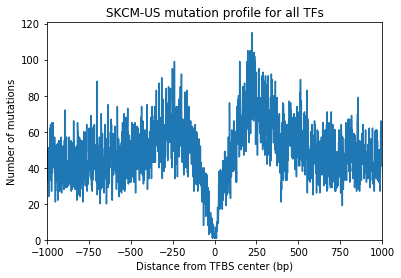

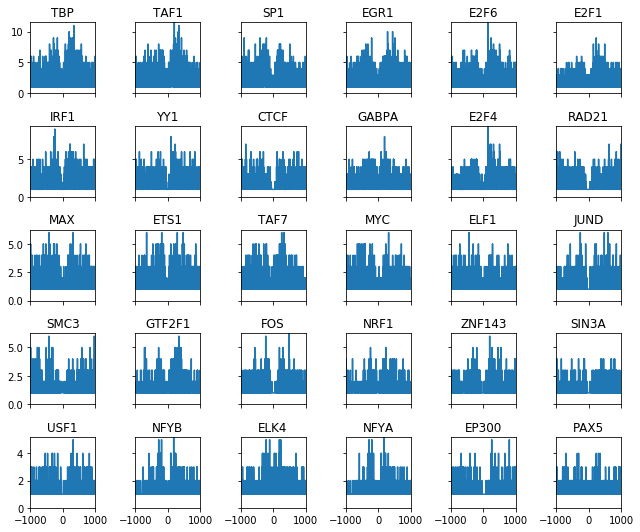

In [100]:
%matplotlib inline

name = "SKCM-US"
plot_dists(all_counts[name], name)
plot_dists_by_tf(all_counts_by_tf[name], name)

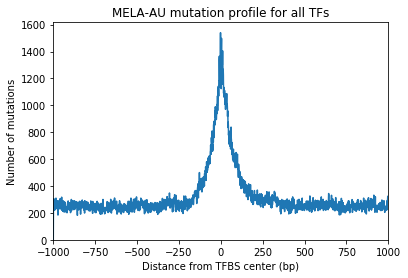

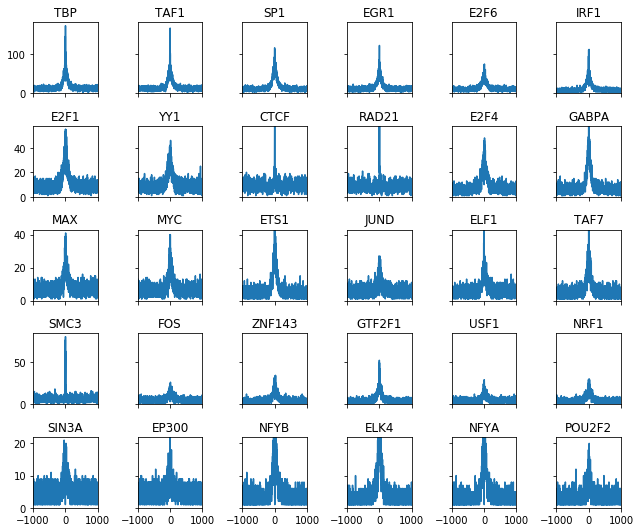

In [101]:
%matplotlib inline

name = "MELA-AU"
plot_dists(all_counts[name], name)
plot_dists_by_tf(all_counts_by_tf[name], name)

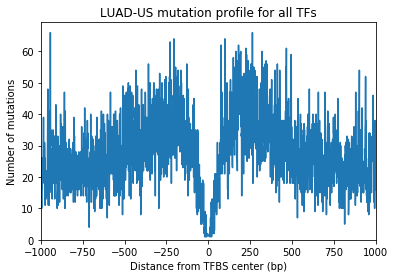

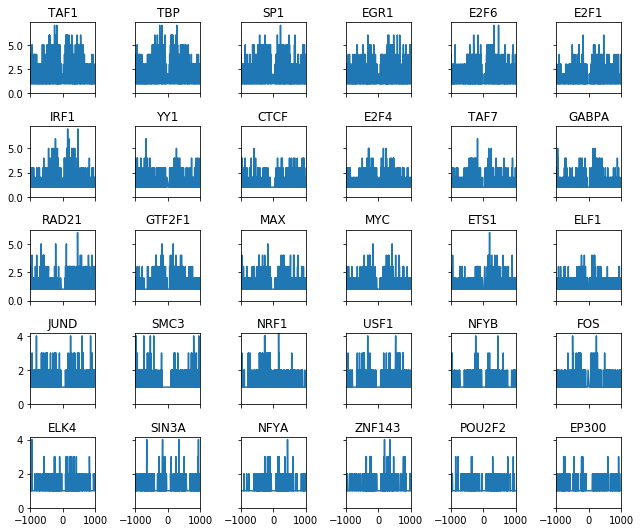

In [102]:
%matplotlib inline

name = "LUAD-US"
plot_dists(all_counts[name], name)
plot_dists_by_tf(all_counts_by_tf[name], name)

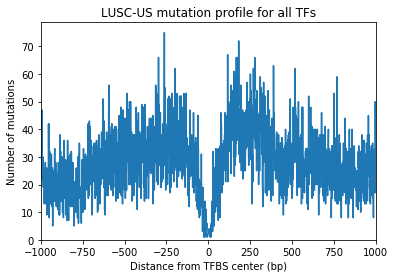

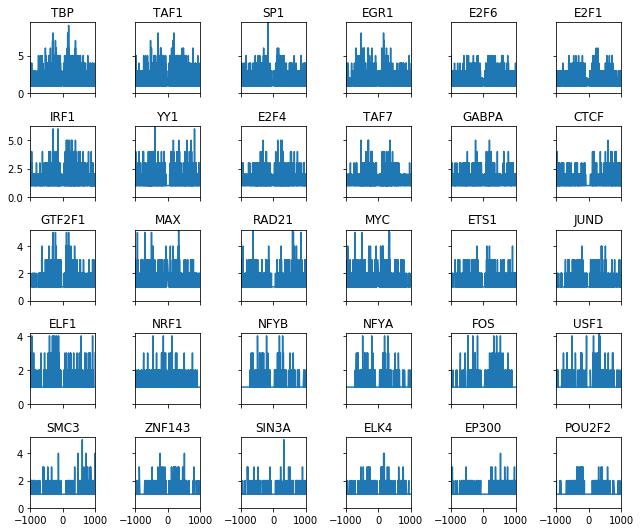

In [103]:
%matplotlib inline

name = "LUSC-US"
plot_dists(all_counts[name], name)
plot_dists_by_tf(all_counts_by_tf[name], name)

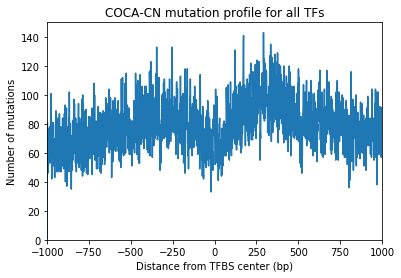

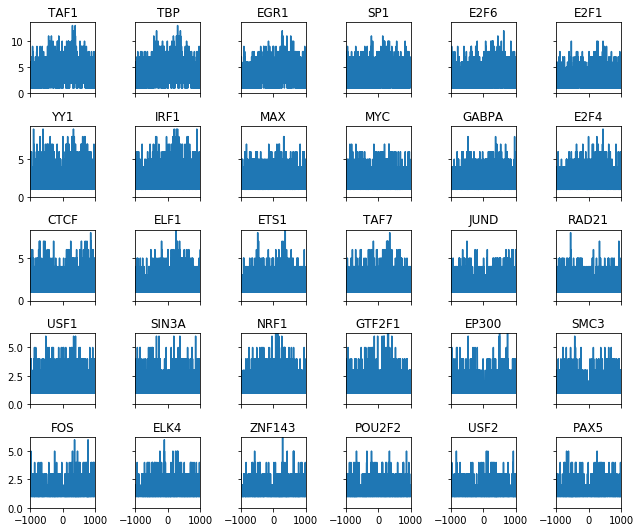

In [104]:
%matplotlib inline

name = "COCA-CN"
plot_dists(all_counts[name], name)
plot_dists_by_tf(all_counts_by_tf[name], name)

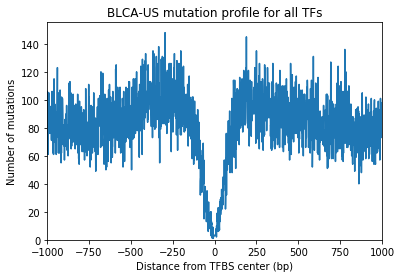

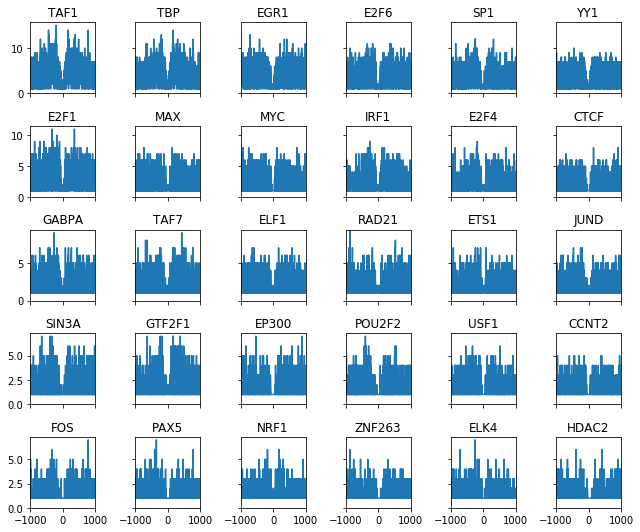

In [105]:
%matplotlib inline

name = "BLCA-US"
plot_dists(all_counts[name], name)
plot_dists_by_tf(all_counts_by_tf[name], name)